<h2>Using SQL in Chinook database</h2>

### Importing libraries 

In [84]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

%matplotlib inline

<hr>

### Creating aux. functions 

In [2]:
def run_query(query):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(query, conn)

In [3]:
def run_command(query):
    with sqlit3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(query)

In [4]:
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


<hr>

<h2>Analysis</h2>

#### Findings the top genres sold in USA 

In [5]:
query1 = '''
WITH table1 AS 
(SELECT
    t.genre_id genre,
    SUM(il.quantity) number_of_tracks_sold
FROM invoice_line il
JOIN track t
ON t.track_id = il.track_id
JOIN invoice i
ON i.invoice_id = il.invoice_id
WHERE i.billing_country = "USA"
GROUP BY t.genre_id),
table2 AS
(SELECT
    SUM(table1.number_of_tracks_sold) total_sum
FROM table1
)

SELECT
    g.name,
    table1.number_of_tracks_sold,
    ROUND(CAST(CAST(table1.number_of_tracks_sold as float) / 
    (SELECT * FROM table2) AS float)*100, 2) perc_tracks_sold
FROM table1
LEFT JOIN genre g
ON table1.genre = g.genre_id
ORDER BY 3 DESC;
'''

run_query(query1)

,name,number_of_tracks_sold,perc_tracks_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


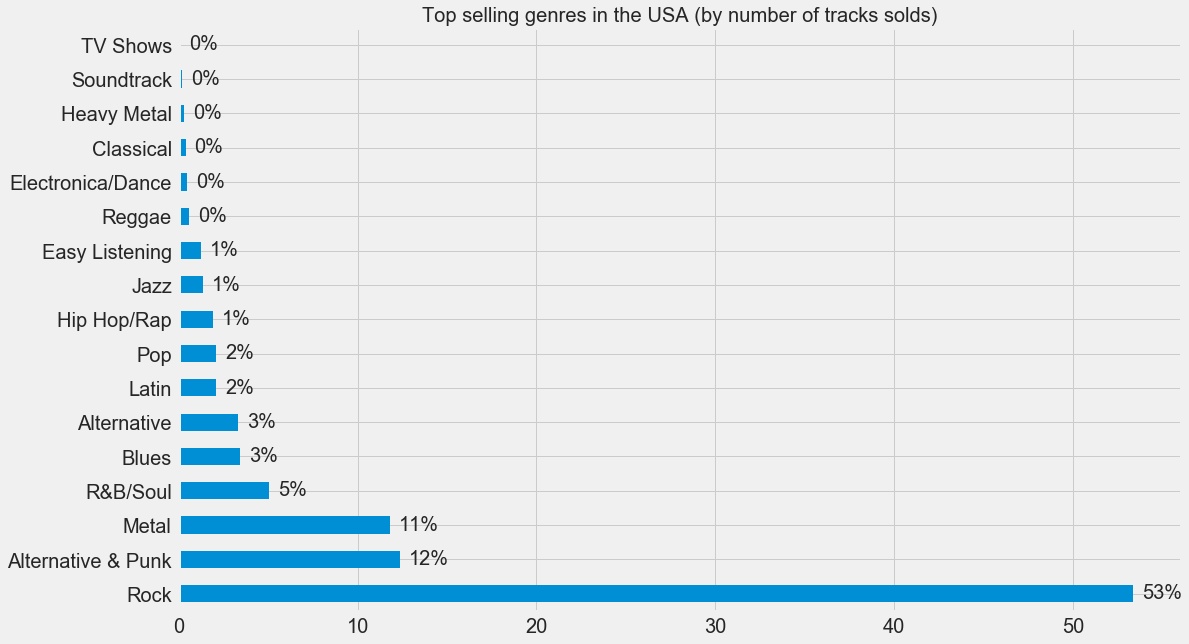

In [9]:
top_genres_usa = run_query(query1)
top_genres_usa.set_index('name', inplace=True)

## Setting five thirty eight style
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,10))
top_genres_usa['perc_tracks_sold'].plot.barh(
title='Top selling genres in the USA (by number of tracks solds)');
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('')

plt.ylabel('')

for i, label in enumerate(list(top_genres_usa.index)):
    score = top_genres_usa.loc[label, "perc_tracks_sold"]
    label = (top_genres_usa.loc[label, "perc_tracks_sold"]
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 0.5, i - 0.15), size=20)

plt.show()

#### Finding best employees 

In [10]:
query2 = '''
SELECT
    e.first_name || ' ' || e.last_name employee_name,
    e.hire_date,
    SUM(i.total) total_sales
FROM employee e
JOIN customer c
ON c.support_rep_id = e.employee_id
JOIN invoice i
ON c.customer_id = i.customer_id
GROUP BY 1, 2
ORDER BY 3 DESC;'''

run_query(query2)

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


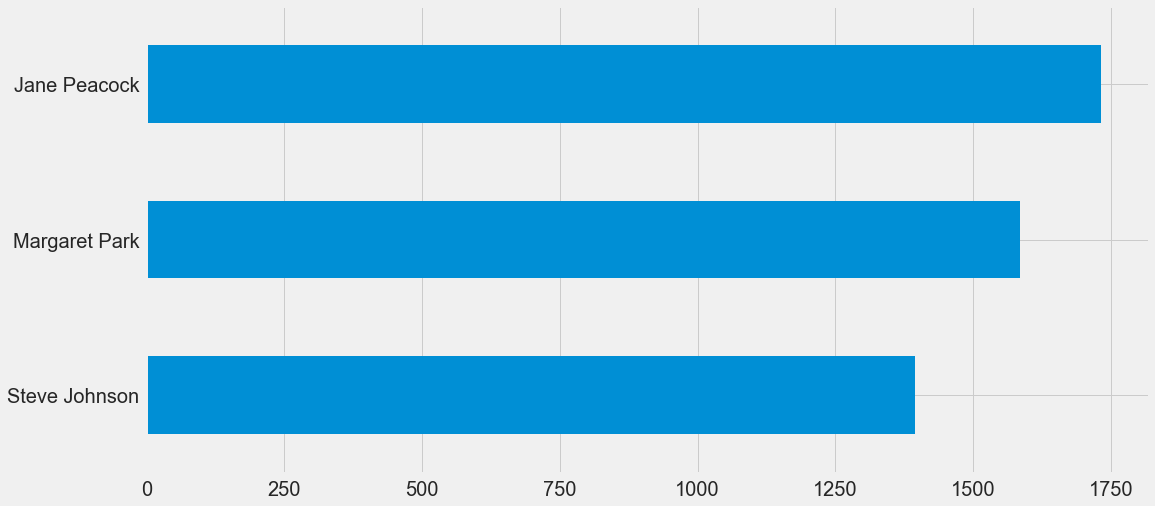

In [11]:
best_employees = run_query(query2)
best_employees.set_index('employee_name', inplace=True)
best_employees.sort_values('total_sales', inplace=True)

## Setting five thirty eight style
plt.style.use('fivethirtyeight')
plt.figure(figsize=(16,8))
best_employees['total_sales'].plot.barh()
title='Total sales by employee';
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('')

#### Data purchases from different countries 

Include:
- Total number of customers
- Total value of sales
- average value of sales per customer
- Average order value

In [61]:
query3 = '''
WITH table1 AS
(
    SELECT
        c.country,
        COUNT(DISTINCT(c.customer_id)) number_of_customers,
        SUM(i.total) total_value_sales,
        COUNT(DISTINCT(i.invoice_id)) number_of_sales
    FROM customer c
    LEFT JOIN invoice i
    ON i.customer_id = c.customer_id
    GROUP BY c.country
),
table2 AS
(
    SELECT
        *,
        (CASE
            WHEN number_of_customers = 1 THEN 'Others'
            ELSE country
        END) AS country_group
    FROM table1
),
table3 AS
(
    SELECT
        country_group,
        SUM(number_of_customers) number_of_customers,
        SUM(total_value_sales) total_value_sales,
        SUM(number_of_sales) number_of_sales
    FROM table2
    GROUP BY 1
),
table4 AS
(
    SELECT 
        *,
        (total_value_sales / number_of_sales) avg_value_per_sale,
        (total_value_sales / number_of_customers) avg_value_per_customer,
        CASE 
            WHEN country_group = "Others" THEN 1
            ELSE 0
        END AS flag_others
    FROM table3
)

SELECT 
    *
FROM table4
ORDER BY flag_others, total_value_sales DESC;

'''
run_query(query3)

,country_group,number_of_customers,total_value_sales,number_of_sales,avg_value_per_sale,avg_value_per_customer,flag_others
0,USA,13,1040.49,131,7.942672,80.037692,0
1,Canada,8,535.59,76,7.047237,66.948750,0
2,Brazil,5,427.68,61,7.011148,85.536000,0
3,France,5,389.07,50,7.781400,77.814000,0
4,Germany,4,334.62,41,8.161463,83.655000,0
5,Czech Republic,2,273.24,30,9.108000,136.620000,0
6,United Kingdom,3,245.52,28,8.768571,81.840000,0
7,Portugal,2,185.13,29,6.383793,92.565000,0
8,India,2,183.15,21,8.721429,91.575000,0
9,Others,15,1094.94,147,7.448571,72.996000,1


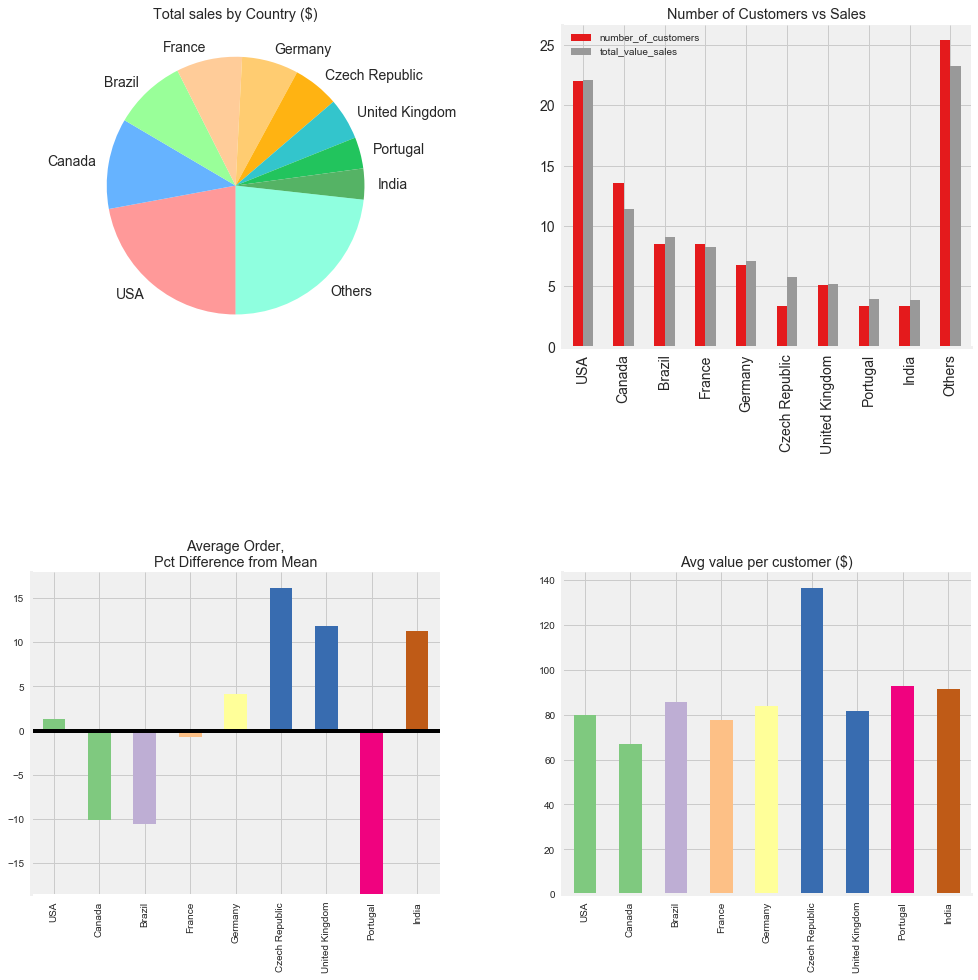

In [124]:
country_metrics = run_query(query3)
country_metrics.set_index('country_group', inplace=True)
cs = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#ffcc71', '#ffb312', '#33c5cc', '#22c45d',
      '#55b365', '#11ffbb77']

## Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15,16))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.7, wspace=.3)
ax1.axis('equal')

# Top left
country_metrics['total_value_sales'].plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    colors=cs,
    title='Total sales by Country ($)',
    fontsize=14)
ax1.set_ylabel('');

# Top right
filt = ["number_of_customers","total_value_sales"]
top_right = country_metrics[filt].copy()
top_right.index.name = ''
for c in filt:
    top_right[c] /= top_right[c].sum() / 100
top_right.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Number of Customers vs Sales",
    fontsize=14
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

# Bottom left
bot_left = country_metrics['avg_value_per_sale'].copy()
bot_left.index.name = ''
difference_from_avg = bot_left * 100 / bot_left.mean() - 100
difference_from_avg.drop("Others", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
bot_right = country_metrics["avg_value_per_customer"].copy()
bot_right.index.name = ''
bot_right.drop("Others",inplace=True)
bot_right.plot.bar(
    ax=ax4,
    color=colors,
    title="Avg value per customer ($)"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

<hr>